In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Upload kaggle.json
from google.colab import files
files.upload()  # Select your kaggle.json file

# ✅ Rename and move the file properly
!mkdir -p ~/.kaggle
!mv "kaggle (3).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# ✅ Install Kaggle CLI (if not already installed)
!pip install -q kaggle

# ✅ Download the dataset
!kaggle datasets download -d phileinsophos/predict-loan-amount-data

# ✅ Unzip the downloaded file
!unzip -o predict-loan-amount-data.zip


Saving kaggle (3).json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/phileinsophos/predict-loan-amount-data
License(s): CC0-1.0
  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 544MB/s]
Archive:  predict-loan-amount-data.zip
  inflating: test.csv                
  inflating: train.csv               


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# My Dataset
df = pd.read_csv('train.csv')
print(df.columns)


Index(['Customer ID', 'Name', 'Gender', 'Age', 'Income (USD)',
       'Income Stability', 'Profession', 'Type of Employment', 'Location',
       'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
       'Expense Type 1', 'Expense Type 2', 'Dependents', 'Credit Score',
       'No. of Defaults', 'Has Active Credit Card', 'Property ID',
       'Property Age', 'Property Type', 'Property Location', 'Co-Applicant',
       'Property Price', 'Loan Sanction Amount (USD)'],
      dtype='object')


**2. Data Preprocessing**

In [3]:
import pandas as pd
from sklearn.impute import SimpleImputer

# 2. Data Preprocessing
# ---------------- Remove unnecessary columns ------------- #

df.drop(columns=['Name', 'Customer ID'], inplace=True)

print(df.columns)
# ---------------- Handling missing values ---------------- #
# replace unknown values with np.nan

df = df.replace(r'(?i)^\s*unknown\s*$', np.nan, regex=True)

print(df.isna().sum())


# Define numerical columns (excluding target)
num_cols = ['Income (USD)', 'Credit Score', 'Current Loan Expenses (USD)',
            'Dependents', 'Property Age']

# Define categorical columns
cat_cols = ['Gender', 'Income Stability', 'Type of Employment',
            'Has Active Credit Card', 'Property Location']

# --------------------------
# Impute numerical with MEDIAN
# --------------------------
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# --------------------------
# Impute categorical with MODE
# --------------------------
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# Handle target variable (Loan Sanction Amount)
# --------------------------

# Leave missing target values as-is — you'll train only on non-missing rows
print("🔎 Missing values in target before training:", df['Loan Sanction Amount (USD)'].isnull().sum())

#For training later:
df = df[df['Loan Sanction Amount (USD)'].notnull()]
print(df.columns)


Index(['Gender', 'Age', 'Income (USD)', 'Income Stability', 'Profession',
       'Type of Employment', 'Location', 'Loan Amount Request (USD)',
       'Current Loan Expenses (USD)', 'Expense Type 1', 'Expense Type 2',
       'Dependents', 'Credit Score', 'No. of Defaults',
       'Has Active Credit Card', 'Property ID', 'Property Age',
       'Property Type', 'Property Location', 'Co-Applicant', 'Property Price',
       'Loan Sanction Amount (USD)'],
      dtype='object')
Gender                           53
Age                               0
Income (USD)                   4576
Income Stability               1683
Profession                        0
Type of Employment             7270
Location                          0
Loan Amount Request (USD)         0
Current Loan Expenses (USD)     172
Expense Type 1                    0
Expense Type 2                    0
Dependents                     2493
Credit Score                   1703
No. of Defaults                   0
Has Active Credit C

In [4]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# Convert 'y' and 'n' to 1 and 0
df['Expense Type 1'] = df['Expense Type 1'].map({'Y': 1, 'N': 0})
df['Expense Type 2'] = df['Expense Type 2'].map({'Y': 1, 'N': 0})


# Define categorical columns
categorical_cols = [
    'Gender',
    'Income Stability',
    'Profession',
    'Type of Employment',
    'Location',
    'Has Active Credit Card',
    'Property Location'
]

# Separate features and target if needed (assume target not encoded)
X = df.copy()

# Define ColumnTransformer with OneHotEncoder (drop='first' to avoid multicollinearity)
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep other columns
)

# Fit and transform the data
X_encoded_array = column_transformer.fit_transform(X)

# Get new column names from the encoder
encoded_cat_cols = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Create DataFrame with encoded data
df_encoded = pd.DataFrame(X_encoded_array, columns=encoded_cat_cols.tolist() + [col for col in X.columns if col not in categorical_cols])

# Optional: Convert all columns to appropriate types
df_encoded = df_encoded.convert_dtypes()

# Reset index if needed
df_encoded.index = df.index

# Output
print(df_encoded.head())
print(df_encoded.columns)
df = df_encoded
print(df.columns)
print("Combined shape:", df.shape)
print("Encoded shape:", df.shape)
print("Memory used:", df.memory_usage(deep=True).sum() / (1024**2), "MB")


   Gender_M  Income Stability_Low  Profession_Commercial associate  \
0         0                     1                                0   
1         1                     1                                0   
2         0                     0                                0   
3         0                     0                                0   
4         0                     1                                0   

   Profession_Maternity leave  Profession_Pensioner  Profession_State servant  \
0                           0                     0                         0   
1                           0                     0                         0   
2                           0                     1                         0   
3                           0                     1                         0   
4                           0                     0                         0   

   Profession_Student  Profession_Unemployed  Profession_Working  \
0                   0   

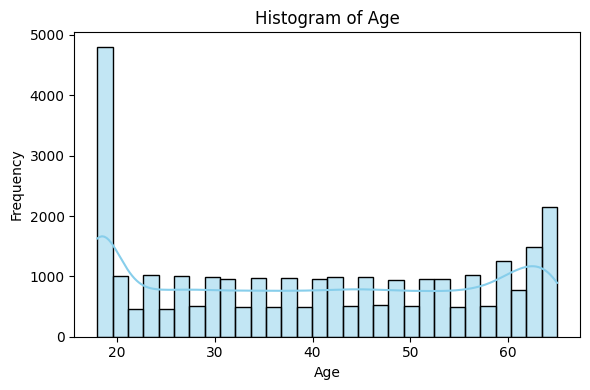

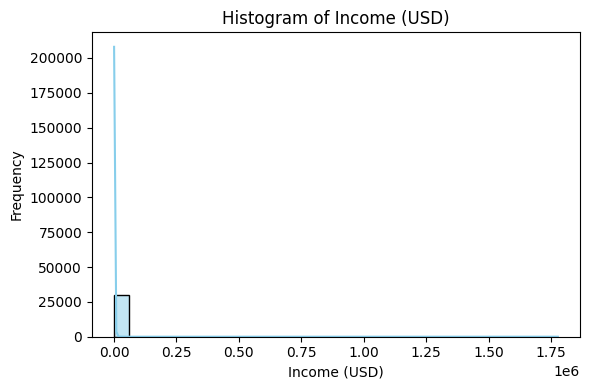

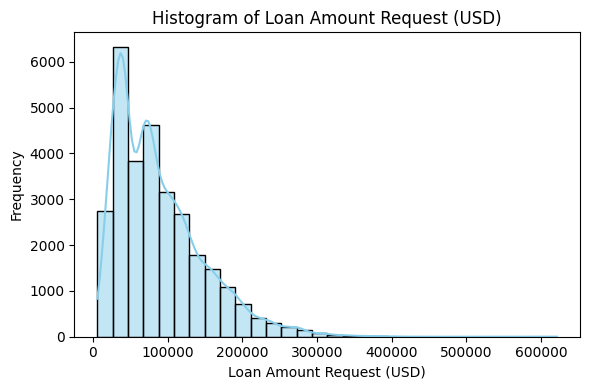

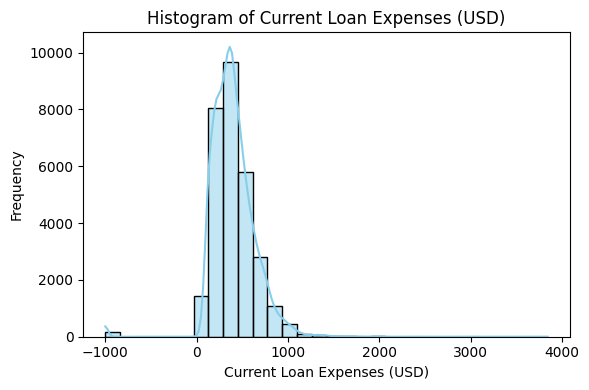

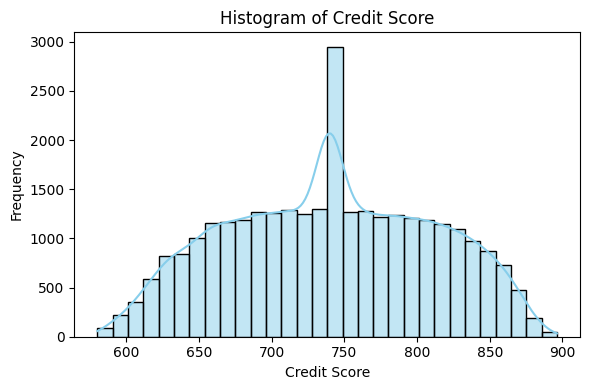

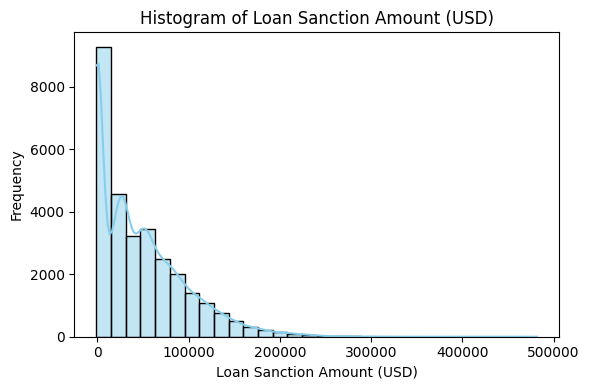

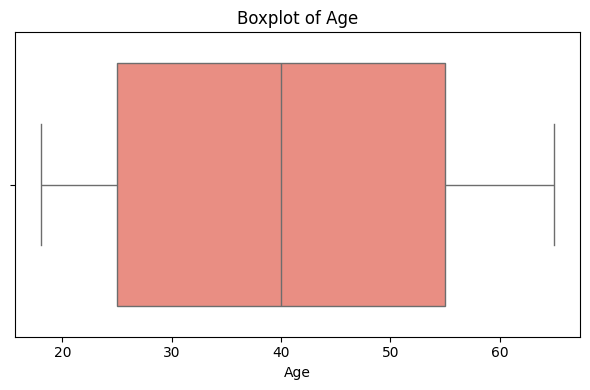

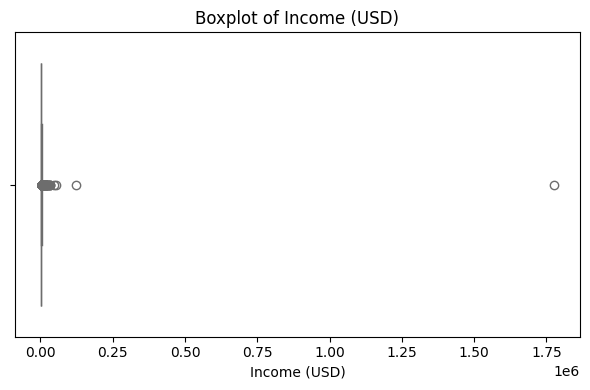

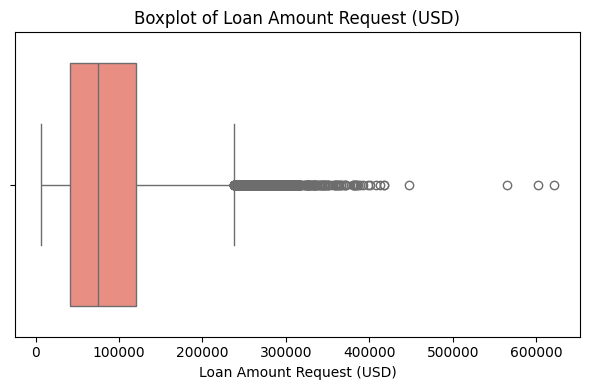

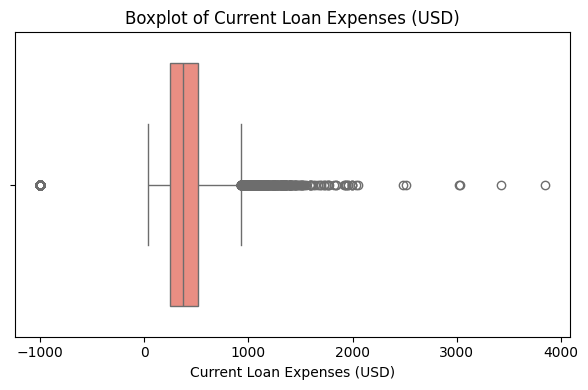

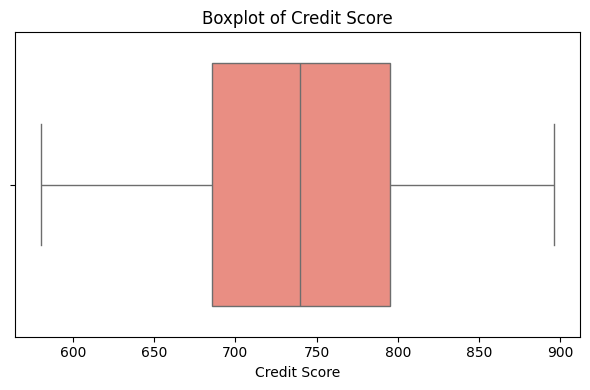

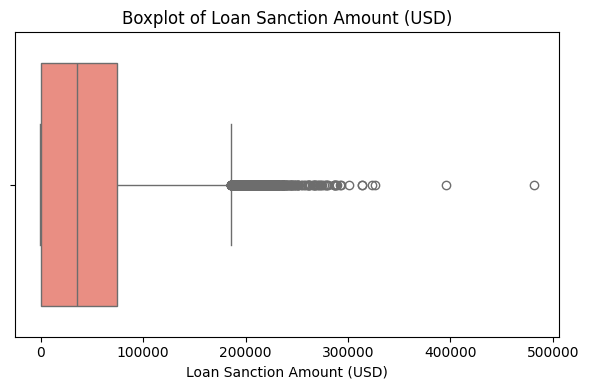

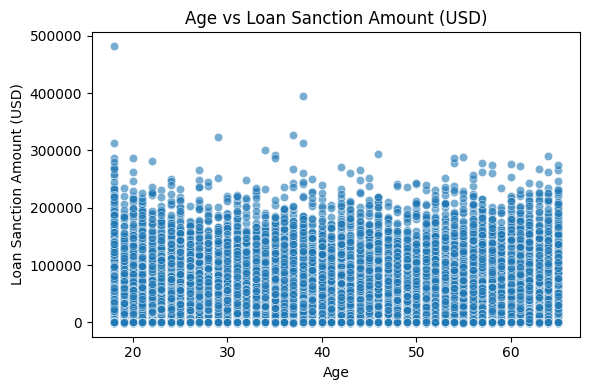

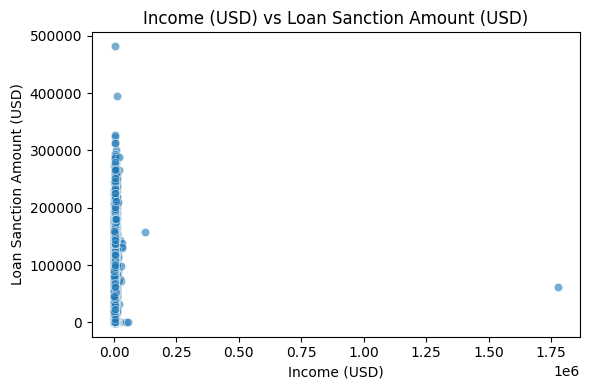

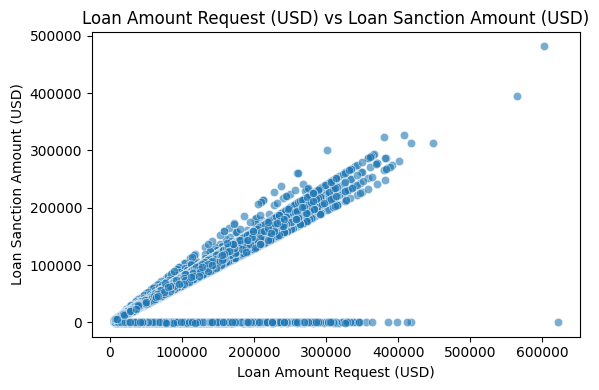

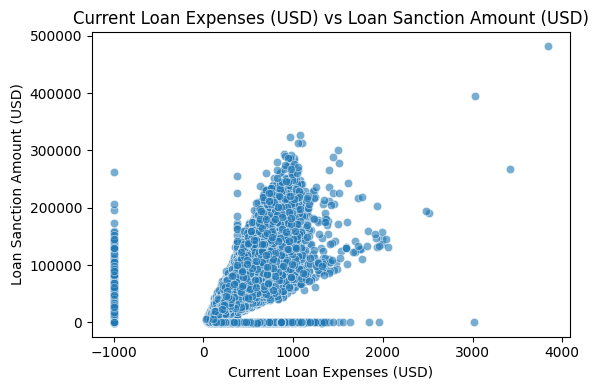

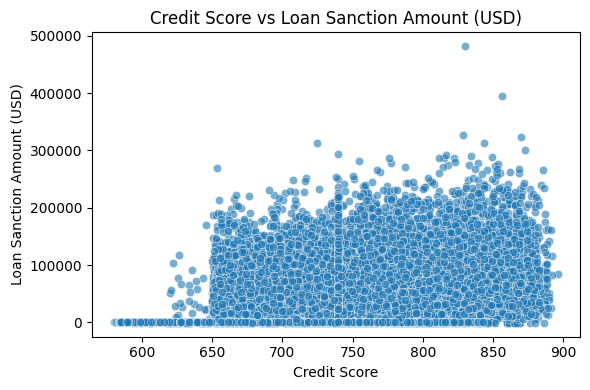

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features
features = ['Age', 'Income (USD)', 'Loan Amount Request (USD)',
            'Current Loan Expenses (USD)', 'Credit Score',
            'Loan Sanction Amount (USD)']

# Histograms
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    plt.close()

# Boxplots
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()
    plt.close()

# Scatter plots against Loan Sanction Amount
target = 'Loan Sanction Amount (USD)'
for col in features:
    if col != target:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col], y=df[target], alpha=0.6)
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()
        plt.close()


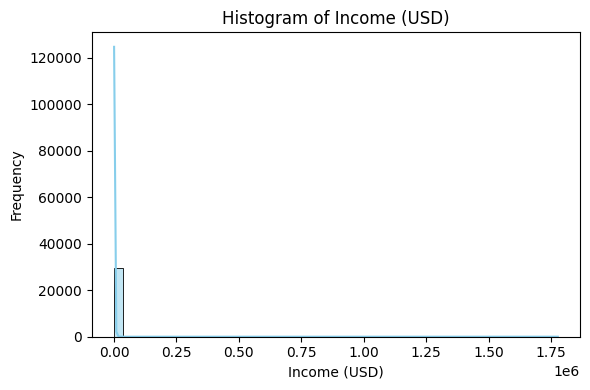

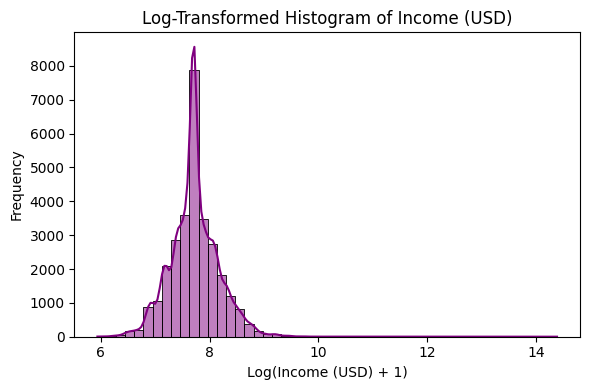

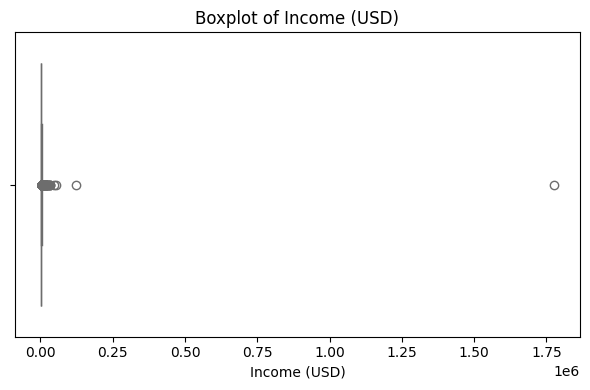

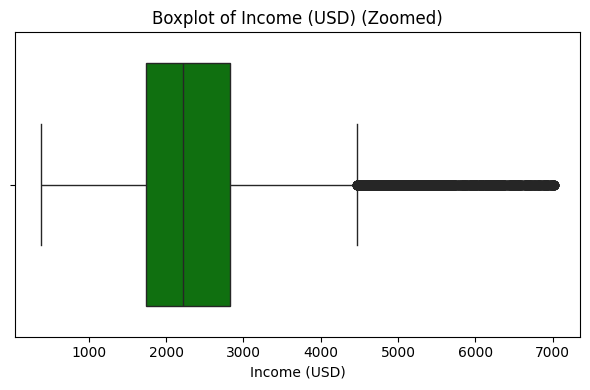

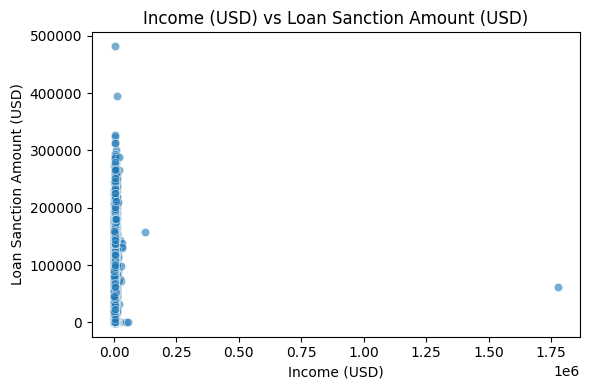

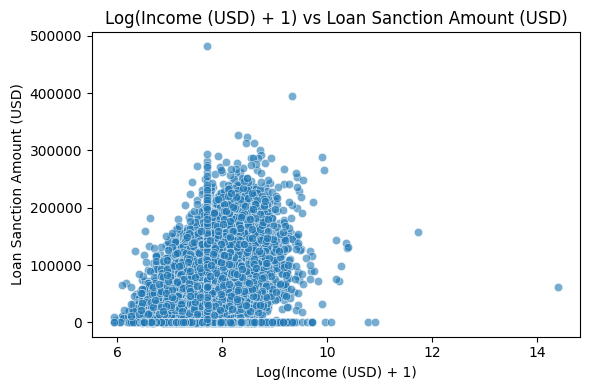

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df is already loaded and cleaned

# Feature to visualize
income_col = 'Income (USD)'
target_col = 'Loan Sanction Amount (USD)'

# Histogram (Raw)
plt.figure(figsize=(6, 4))
sns.histplot(df[income_col], kde=True, bins=50, color='skyblue')
plt.title(f'Histogram of {income_col}')
plt.xlabel(income_col)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.close()

# Histogram (Log Transformed)
plt.figure(figsize=(6, 4))
sns.histplot(np.log1p(df[income_col]), kde=True, bins=50, color='purple')
plt.title(f'Log-Transformed Histogram of {income_col}')
plt.xlabel(f'Log({income_col} + 1)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.close()

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df[income_col], color='salmon')
plt.title(f'Boxplot of {income_col}')
plt.tight_layout()
plt.show()
plt.close()
# Boxplot (Zoomed, remove extreme outliers at 99th percentile)
plt.figure(figsize=(6, 4))
filtered_income = df[df[income_col] < df[income_col].quantile(0.99)]
sns.boxplot(x=filtered_income[income_col], color='green')
plt.title(f'Boxplot of {income_col} (Zoomed)')
plt.tight_layout()
plt.show()
plt.close()

# Scatter Plot: Income vs Loan Sanction Amount
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df[income_col], y=df[target_col], alpha=0.6)
plt.title(f'{income_col} vs {target_col}')
plt.xlabel(income_col)
plt.ylabel(target_col)
plt.tight_layout()
plt.show()
plt.close()

# Scatter Plot with log-transformed income
plt.figure(figsize=(6, 4))
sns.scatterplot(x=np.log1p(df[income_col]), y=df[target_col], alpha=0.6)
plt.title(f'Log({income_col} + 1) vs {target_col}')
plt.xlabel(f'Log({income_col} + 1)')
plt.ylabel(target_col)
plt.tight_layout()
plt.show()
plt.close()


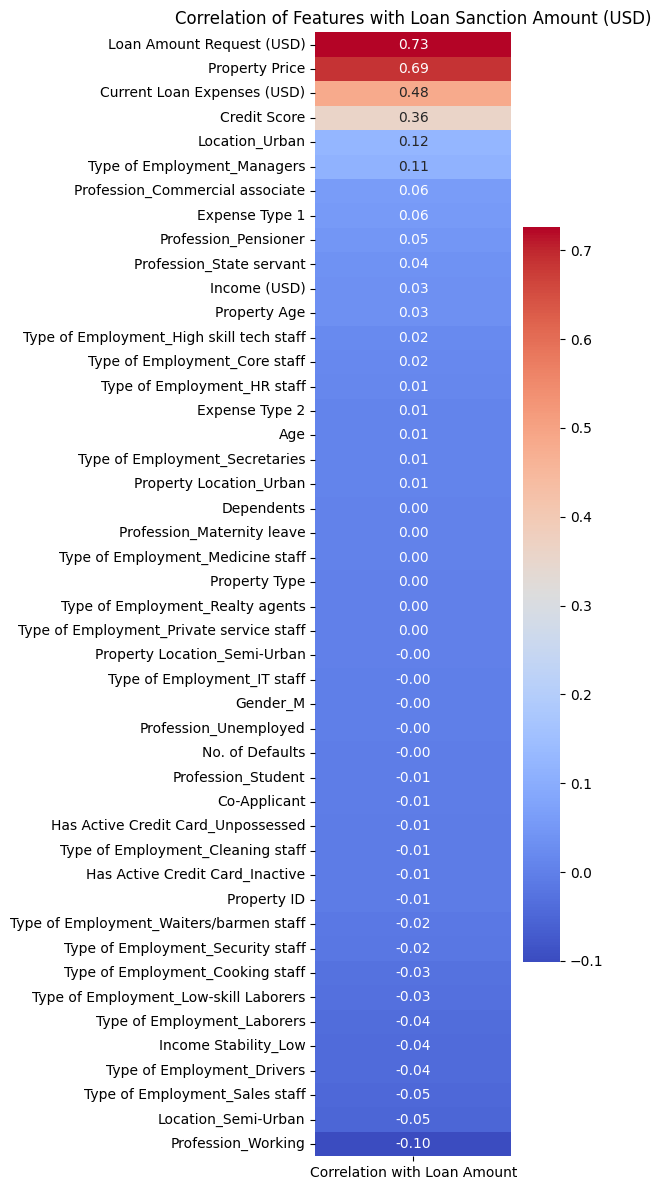

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure only numerical columns are used for correlation
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlations with the target column
target_col = 'Loan Sanction Amount (USD)'
correlations = {}

for col in numerical_df.columns:
    if col != target_col:
        correlations[col] = numerical_df[col].corr(numerical_df[target_col])

# Convert to DataFrame for heatmap
corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Loan Amount'])
corr_df = corr_df.sort_values(by='Correlation with Loan Amount', ascending=False)

# Plotting heatmap
plt.figure(figsize=(6, 12))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title(f'Correlation of Features with {target_col}')
plt.tight_layout()
plt.show()
plt.close()


**Normalization**

In [9]:
import pandas as pd
import numpy as np

# Sample: Load your dataset
# df = pd.read_csv('your_dataset.csv')

# --- Function to cap outliers using IQR ---
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound,
                  np.where(df[column] > upper_bound, upper_bound, df[column]))

# --- List of columns to cap using IQR ---
columns_to_cap = [
    'Income (USD)',
    'Loan Amount Request (USD)',
    'Current Loan Expenses (USD)',
    'Loan Sanction Amount (USD)'
]




# 1. Z-score: Income
df['Income (USD)'] = (
    df['Income (USD)'] - df['Income (USD)'].mean()
) / df['Income (USD)'].std()

# 2. Z-score: Loan Amount Request
df['Loan Amount Request (USD)'] = (
    df['Loan Amount Request (USD)'] - df['Loan Amount Request (USD)'].mean()
) / df['Loan Amount Request (USD)'].std()

# 3. Standardize: Current Loan Expenses (already Z-scored correctly)
df['Current Loan Expenses (USD)'] = (
    df['Current Loan Expenses (USD)'] - df['Current Loan Expenses (USD)'].mean()
) / df['Current Loan Expenses (USD)'].std()

# 4. Standardize: Credit Score (already Z-scored correctly)
df['Credit Score'] = (
    df['Credit Score'] - df['Credit Score'].mean()
) / df['Credit Score'].std()

# 5. Z-score: Loan Sanction Amount (Target Variable)
df['Loan Sanction Amount (USD)'] = (
    df['Loan Sanction Amount (USD)'] - df['Loan Sanction Amount (USD)'].mean()
) / df['Loan Sanction Amount (USD)'].std()

# Apply IQR capping
for col in columns_to_cap:
    cap_outliers_iqr(df, col)

# --- Show transformed data ---
print(df.head())


   Gender_M  Income Stability_Low  Profession_Commercial associate  \
0         0                     1                                0   
1         1                     1                                0   
2         0                     0                                0   
3         0                     0                                0   
4         0                     1                                0   

   Profession_Maternity leave  Profession_Pensioner  Profession_State servant  \
0                           0                     0                         0   
1                           0                     0                         0   
2                           0                     1                         0   
3                           0                     1                         0   
4                           0                     0                         0   

   Profession_Student  Profession_Unemployed  Profession_Working  \
0                   0   

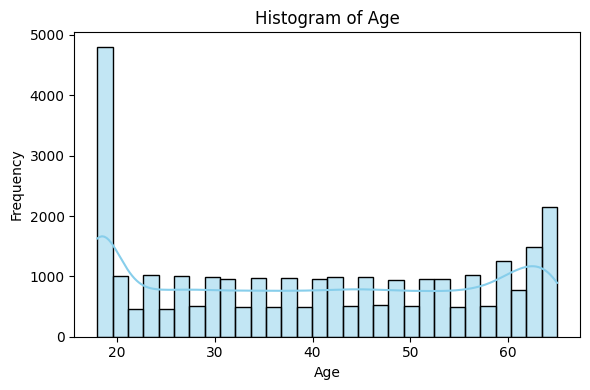

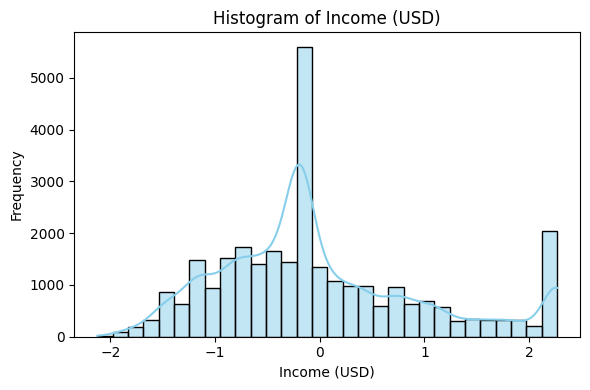

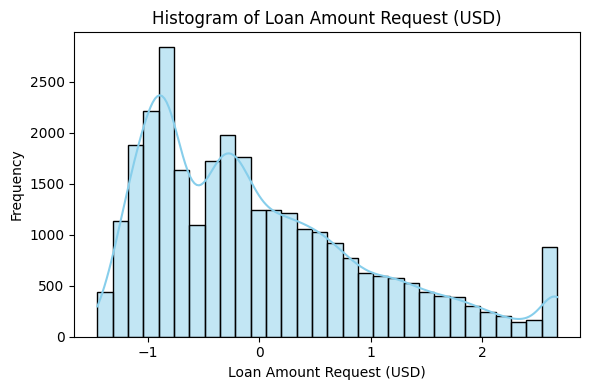

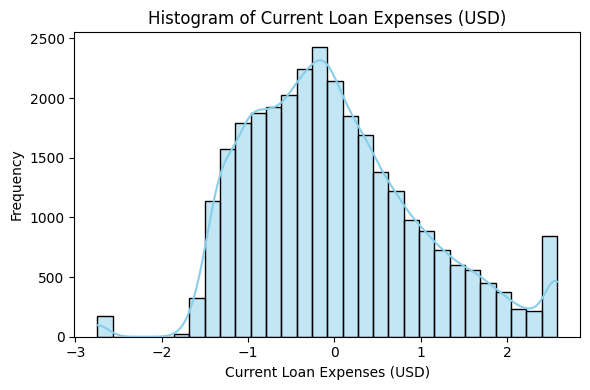

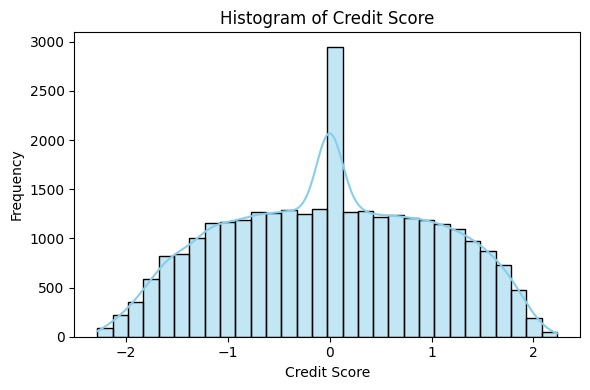

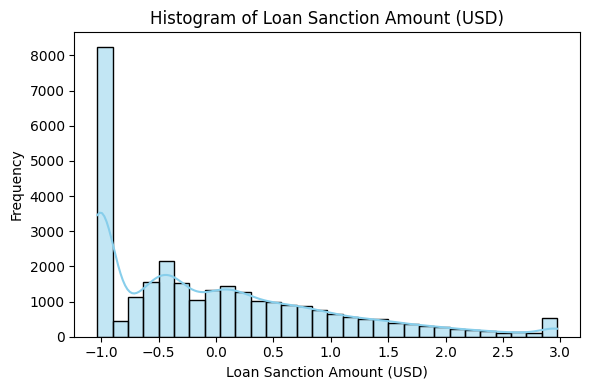

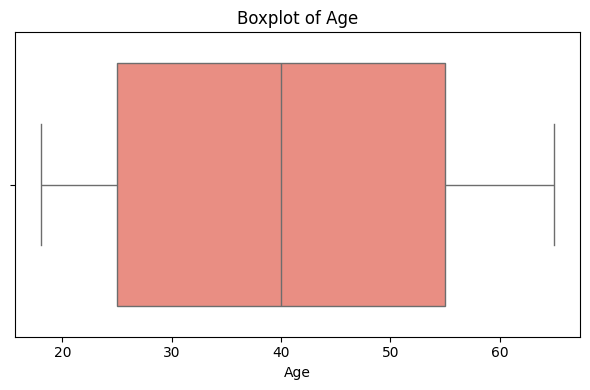

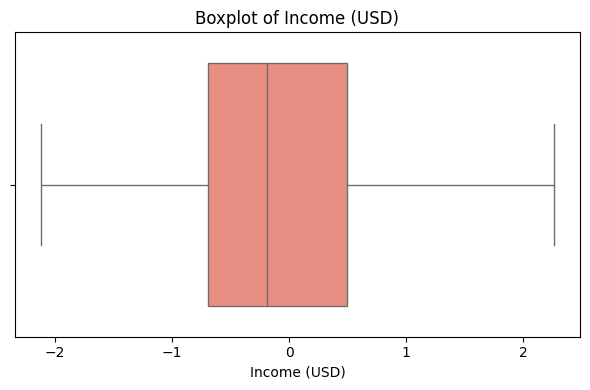

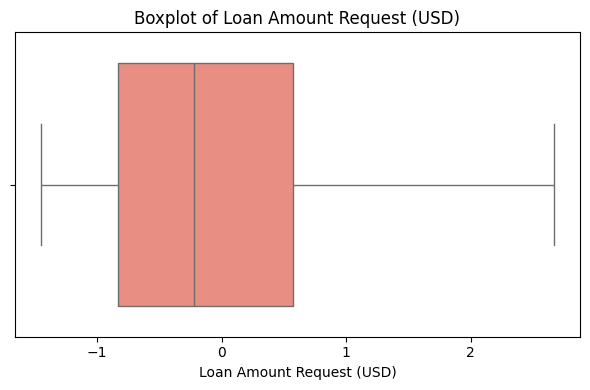

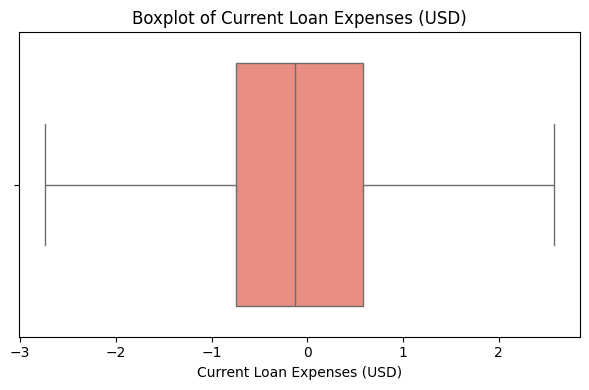

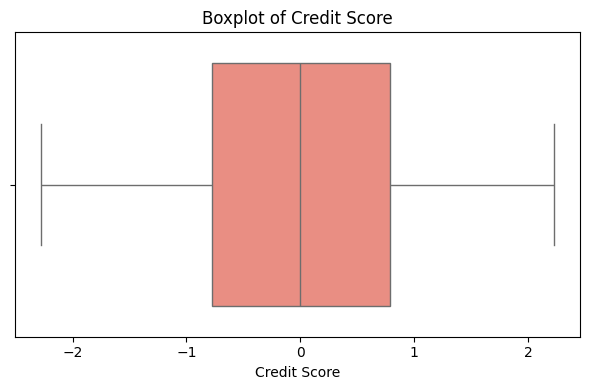

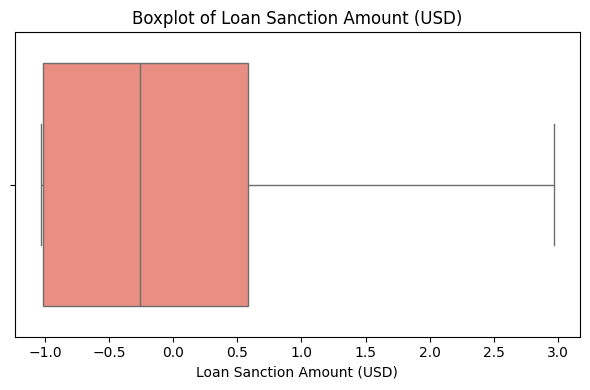

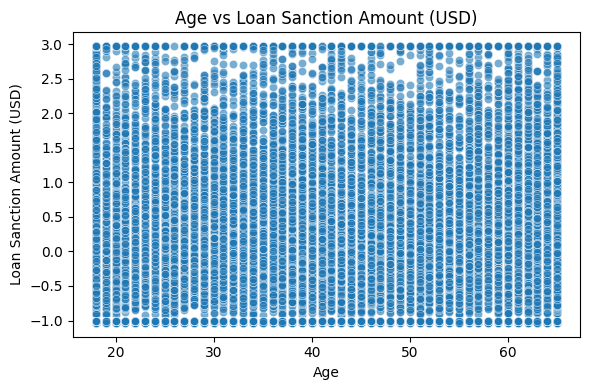

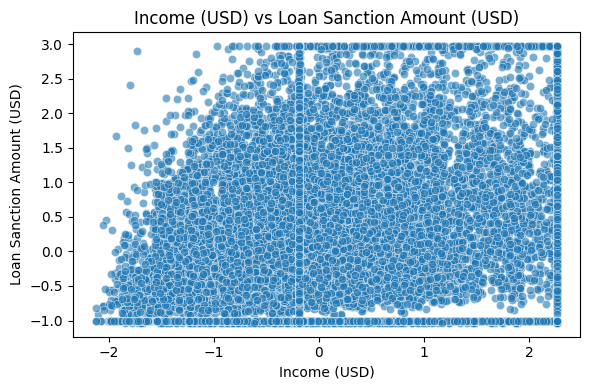

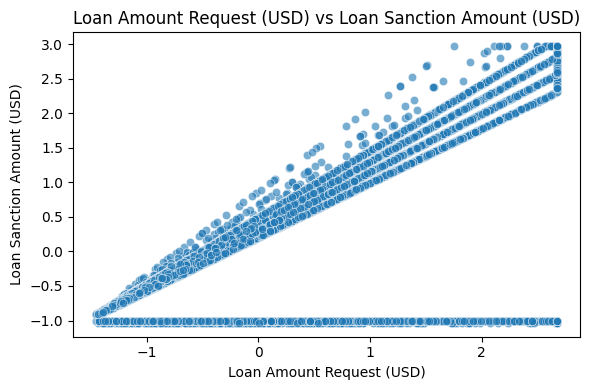

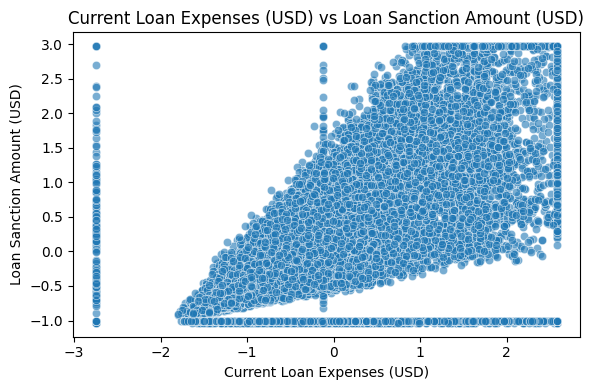

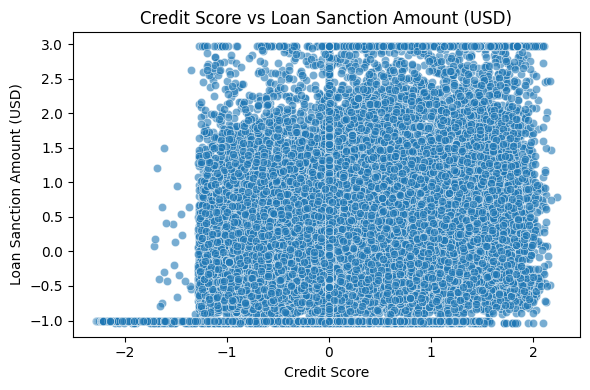

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features
features = ['Age', 'Income (USD)', 'Loan Amount Request (USD)',
            'Current Loan Expenses (USD)', 'Credit Score',
            'Loan Sanction Amount (USD)']

# Histograms
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    plt.close()

# Boxplots
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col], color='salmon')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()
    plt.close()

# Scatter plots against Loan Sanction Amount
target = 'Loan Sanction Amount (USD)'
for col in features:
    if col != target:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col], y=df[target], alpha=0.6)
        plt.title(f'{col} vs {target}')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.tight_layout()
        plt.show()
        plt.close()


📊 Test Evaluation Metrics:
➡ Mean Squared Error (MSE): 0.44
➡ Root Mean Squared Error (RMSE): 0.66
➡ Mean Absolute Error (MAE): 0.46
➡ R² Score: 0.5524


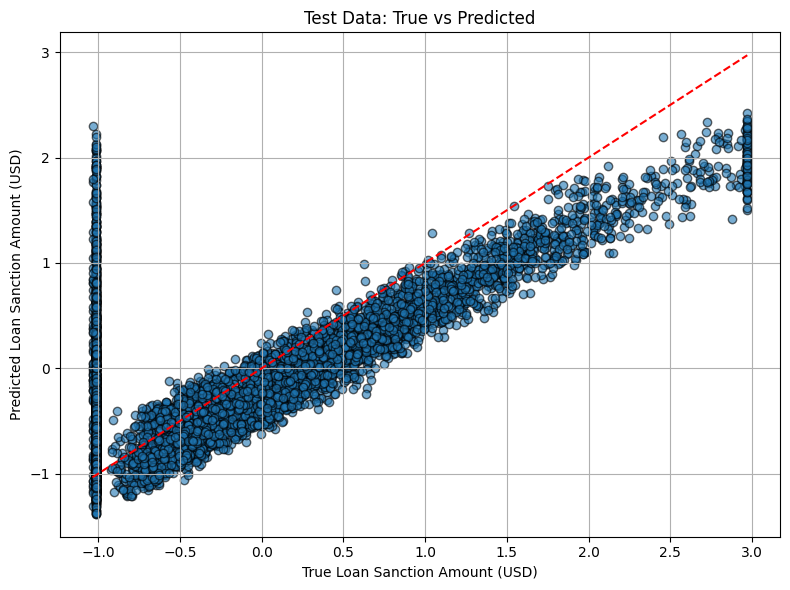

In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Drop rows with missing target ---
df = df.dropna(subset=['Loan Sanction Amount (USD)'])

# --- Step 2: Define features and target ---
X = df.drop(columns=['Loan Sanction Amount (USD)'])
y = df['Loan Sanction Amount (USD)']

# --- Step 3: Apply Z-score normalization to target variable ---
y_mean = y.mean()
y_std = y.std()
y_z = (y - y_mean) / y_std

# --- Step 4: Train-test split (on normalized target) ---
X_train, X_test, y_train_z, y_test_z = train_test_split(X, y_z, test_size=0.2, random_state=42)

# --- Step 5: Train Linear Regression ---
model = LinearRegression()
model.fit(X_train, y_train_z)

# --- Step 6: Predict on test set ---
y_pred_z = model.predict(X_test)

# --- Step 7: Inverse transform predictions and true values ---
y_pred = y_pred_z * y_std + y_mean
y_test = y_test_z * y_std + y_mean

# --- Step 8: Evaluate the model ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Test Evaluation Metrics:")
print(f"➡ Mean Squared Error (MSE): {mse:.2f}")
print(f"➡ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"➡ Mean Absolute Error (MAE): {mae:.2f}")
print(f"➡ R² Score: {r2:.4f}")

# --- Step 9: Plot: True vs Predicted (on test set) ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.xlabel("True Loan Sanction Amount (USD)")
plt.ylabel("Predicted Loan Sanction Amount (USD)")
plt.title("Test Data: True vs Predicted")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()


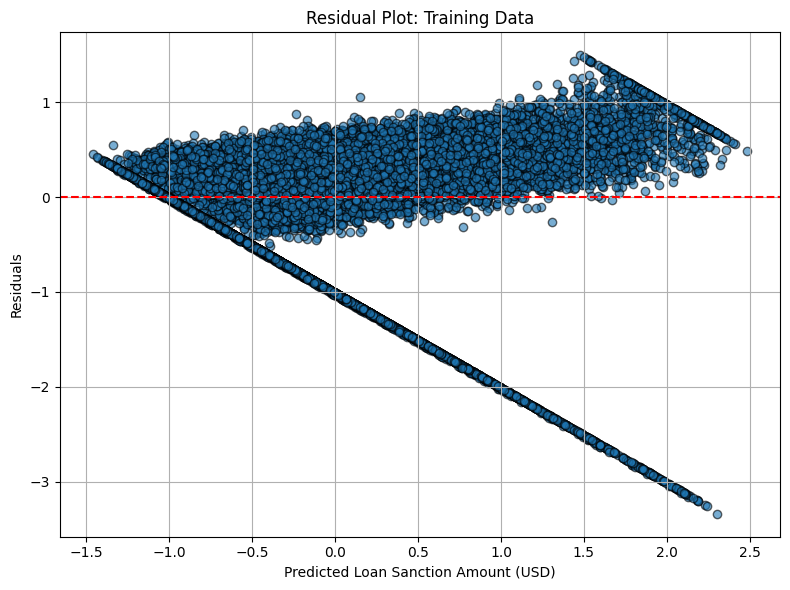

In [17]:
# --- Before residual plot: Predict on training set ---
y_train_pred_z = model.predict(X_train)

# Inverse transform predictions and true values (from z-score back to original scale)
y_train_pred = y_train_pred_z * y_std + y_mean
y_train_true = y_train_z * y_std + y_mean

# --- Residual Plot ---
residuals = y_train_true - y_train_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Loan Sanction Amount (USD)")
plt.ylabel("Residuals")
plt.title("Residual Plot: Training Data")
plt.grid(True)
plt.tight_layout()
plt.show()


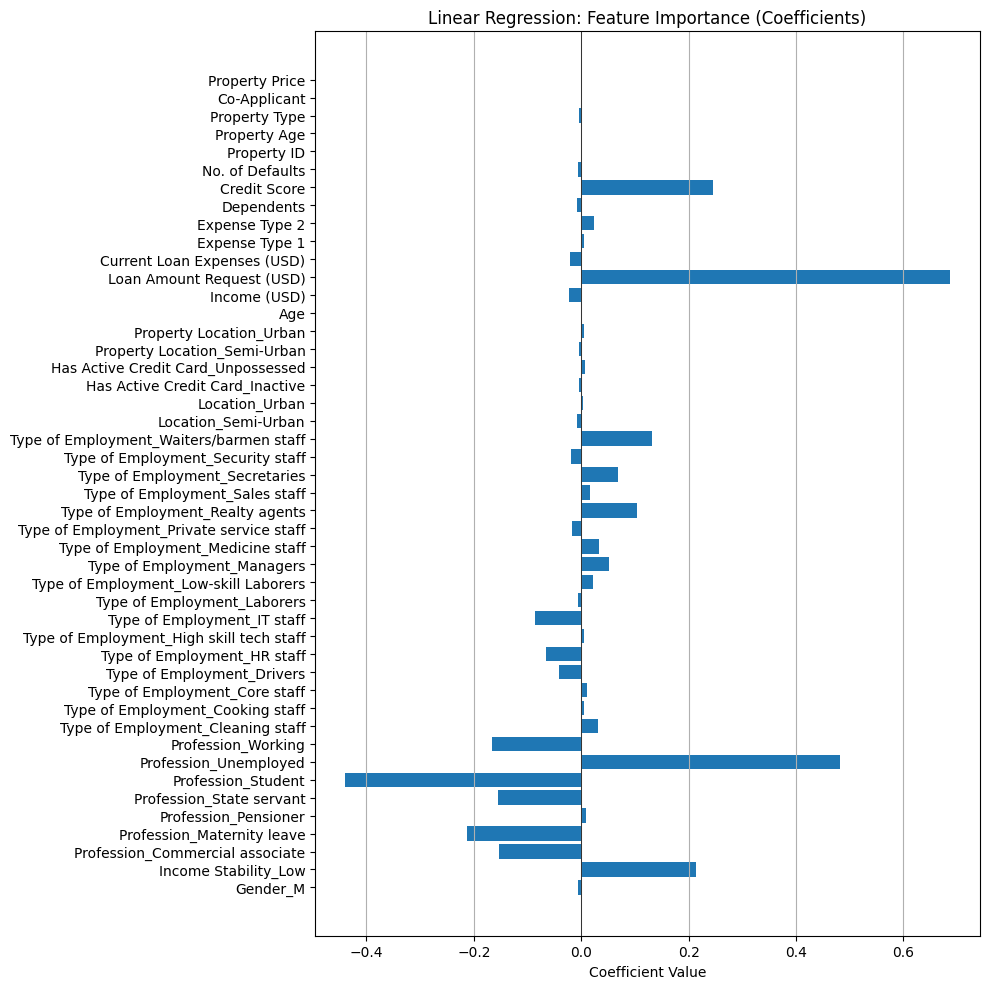

In [16]:
# Bar Plot of Coefficients
coef = model.coef_
features = X.columns

plt.figure(figsize=(10, 10))
plt.barh(features, coef)
plt.xlabel("Coefficient Value")
plt.title("Linear Regression: Feature Importance (Coefficients)")
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold

# --- Step 1: Prepare data ---
# Assuming df is already loaded and cleaned
# Separate features and target
X = df.drop(columns=['Loan Sanction Amount (USD)'])
y = df['Loan Sanction Amount (USD)']

# Z-score normalization on the entire target column
y_mean = y.mean()
y_std = y.std()
y_z = (y - y_mean) / y_std

# --- Step 2: K-Fold Cross-Validation ---
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

results = []
model = LinearRegression()

fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_z, y_test_z = y_z.iloc[train_index], y_z.iloc[test_index]

    # Train model on Z-normalized target
    model.fit(X_train, y_train_z)

    # Predict on Z-normalized target
    y_pred_z = model.predict(X_test)

    # Inverse transform predictions and actual values
    y_pred = y_pred_z * y_std + y_mean
    y_test = y_test_z * y_std + y_mean

    # Evaluate using original (unscaled) target
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Fold': fold,
        'MAE': round(mae, 2),
        'MSE': round(mse, 2),
        'RMSE': round(rmse, 2),
        'R2 Score': round(r2, 4)
    })
    fold += 1

# --- Step 3: Display Results ---
cv_results_df = pd.DataFrame(results)
print(f"Table 1: Cross-Validation Results (K = {k})")
print(cv_results_df)


Table 1: Cross-Validation Results (K = 5)
   Fold   MAE   MSE  RMSE  R2 Score
0     1  0.46  0.44  0.66    0.5524
1     2  0.46  0.43  0.66    0.5631
2     3  0.45  0.41  0.64    0.5809
3     4  0.46  0.41  0.64    0.6017
4     5  0.46  0.44  0.66    0.5643
